In [1]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Run this cell to connect to your Drive folder
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# x_train = np.load('/content/gdrive/MyDrive/GP_dataset/x_train.npy')
# y_train = np.load('/content/gdrive/MyDrive/GP_dataset/y_train.npy')

# x_valid = np.load('/content/gdrive/MyDrive/GP_dataset/x_valid.npy')
# y_valid = np.load('/content/gdrive/MyDrive/GP_dataset/y_valid.npy')
x_test = np.load('/content/gdrive/MyDrive/GP_dataset/x_test.npy')
y_test = np.load('/content/gdrive/MyDrive/GP_dataset/y_test.npy')

In [5]:
# create tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))      # x_train is the train_dataset

In [6]:
  # import tempfile
  # path = os.path.join(tempfile.gettempdir(), "train_dataset")
  # # Save a dataset
  # dataset.save(path)

In [7]:
# callbacks
checkpoint_filepath = '/checkpoint'
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_dice_metric',
    mode='max',
    save_best_only=True,
    verbose= 1)

In [5]:
from tensorflow.keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose, BatchNormalization, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras import backend as K

K.set_image_data_format('channels_last')

project_name = '2D-Dense-Unet'
img_rows = 160
img_cols = 192
img_depth = 1
# 224, 192, 160
 
def dice_metric(y_true, y_pred):
  intersection = K.sum(K.sum(K.abs(y_true * y_pred), axis= -1))
  union = K.sum(K.sum(K.abs(y_true) + K.abs(y_pred), axis= -1))
  return 2*intersection / union

def jaccard_coeff(y_true, y_pred):
  y_true_f = K.flatten(y_true)
  y_pred_f = K.flatten(y_pred)
  intersection = K.sum(y_true_f * y_pred_f)
  return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

def build():
      dropout = 0.5

      inputs = Input((img_rows, img_cols, 2))
      conv11 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
      conc11 = concatenate([inputs, conv11], axis=3)
      conc11 = BatchNormalization()(conc11)
      conv12 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc11)
      conc12 = concatenate([inputs, conv12], axis=3)
      conc12 = BatchNormalization()(conc12)
      pool1 = MaxPooling2D(pool_size=(2, 2))(conc12)
      pool1 = BatchNormalization()(pool1)
      # add dropout
      pool1 = Dropout(rate= dropout)(pool1)

      conv21 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
      conc21 = concatenate([pool1, conv21], axis=3)
      conc21 = BatchNormalization()(conc21)
      conv22 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc21)
      conc22 = concatenate([pool1, conv22], axis=3)
      conc22 = BatchNormalization()(conc22)
      pool2 = MaxPooling2D(pool_size=(2, 2))(conc22)
      pool2 = BatchNormalization()(pool2)
      pool2 = Dropout(rate= dropout)(pool2)

      conv31 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
      conc31 = concatenate([pool2, conv31], axis=3)
      conc31 = BatchNormalization()(conc31)
      conv32 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc31)
      conc32 = concatenate([pool2, conv32], axis=3)
      pool3 = MaxPooling2D(pool_size=(2, 2))(conc32)
      pool3 = BatchNormalization()(pool3)
      pool3 = Dropout(rate= dropout)(pool3)

      conv41 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
      conc41 = concatenate([pool3, conv41], axis=3)
      conc41 = BatchNormalization()(conc41)
      conv42 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc41)
      conc42 = concatenate([pool3, conv42], axis=3)
      pool4 = MaxPooling2D(pool_size=(2, 2))(conc42)
      pool4 = BatchNormalization()(pool4)
      pool4 = Dropout(rate= dropout)(pool4)

      conv51 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
      conc51 = concatenate([pool4, conv51], axis=3)
      conc51 = BatchNormalization()(conc51)
      conv52 = Conv2D(512, (3, 3), activation='relu', padding='same')(conc51)
      conc52 = concatenate([pool4, conv52], axis=3)
      conc52 = BatchNormalization()(conc52)
      conc52 = Dropout(rate= dropout)(conc52)

      up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conc52), conc42], axis=3)
      conv61 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
      conc61 = concatenate([up6, conv61], axis=3)
      conc61 = BatchNormalization()(conc61)
      conv62 = Conv2D(256, (3, 3), activation='relu', padding='same')(conc61)
      conc62 = concatenate([up6, conv62], axis=3)
      conc62 = BatchNormalization()(conc62)
      # add dropout
      conc62 = Dropout(rate= dropout)(conc62)

      up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conc62), conv32], axis=3)
      conv71 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
      conc71 = concatenate([up7, conv71], axis=3)
      conc71 = BatchNormalization()(conc71)
      conv72 = Conv2D(128, (3, 3), activation='relu', padding='same')(conc71)
      conc72 = concatenate([up7, conv72], axis=3)
      conc72 = BatchNormalization()(conc72)
      conc72 = Dropout(rate= dropout)(conc72)

      up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conc72), conv22], axis=3)
      conv81 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
      conc81 = concatenate([up8, conv81], axis=3)
      conc81 = BatchNormalization()(conc81)
      conv82 = Conv2D(64, (3, 3), activation='relu', padding='same')(conc81)
      conc82 = concatenate([up8, conv82], axis=3)
      conc82 = BatchNormalization()(conc82)
      conc82 = Dropout(rate= dropout)(conc82)

      up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conc82), conv12], axis=3)
      conv91 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
      conc91 = concatenate([up9, conv91], axis=3)
      conc91 = BatchNormalization()(conc91)
      conv92 = Conv2D(32, (3, 3), activation='relu', padding='same')(conc91)
      conc92 = concatenate([up9, conv92], axis=3)
      conc92 = BatchNormalization()(conc92)


      conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conc92)

      model = tf.keras.Model(inputs=[inputs], outputs=[conv10])   

    
      model.compile(optimizer=Adam(learning_rate= 0.001), loss='binary_crossentropy', metrics=['accuracy', dice_metric, jaccard_coeff])
      
      return model

In [6]:
model = build()
# model.summary()

In [ ]:
# train model
EPOCHS = 50     
BUFFER_SIZE = 500
BATCH_SIZE = 16

dataset.batch(BATCH_SIZE)
dataset = dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
model_history = model.fit(dataset,validation_data= (x_valid, y_valid), epochs=EPOCHS, callbacks=[checkpoint_callback])

In [ ]:
model.save('/content/gdrive/MyDrive/gp_models/2ch_125pat_50epoch/model')
np.save('/content/gdrive/MyDrive/gp_models/2ch_125pat_50epoch/my_history.npy',model_history.history)

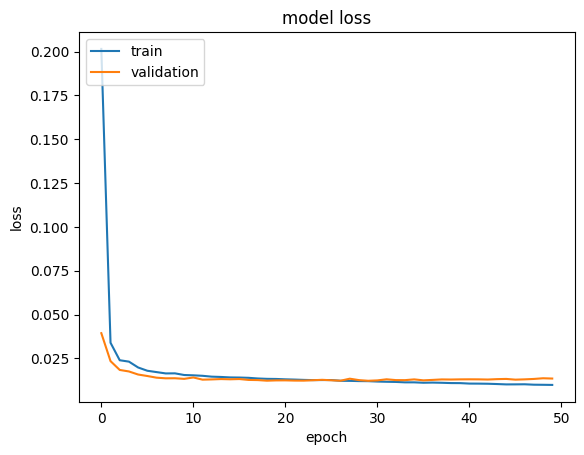

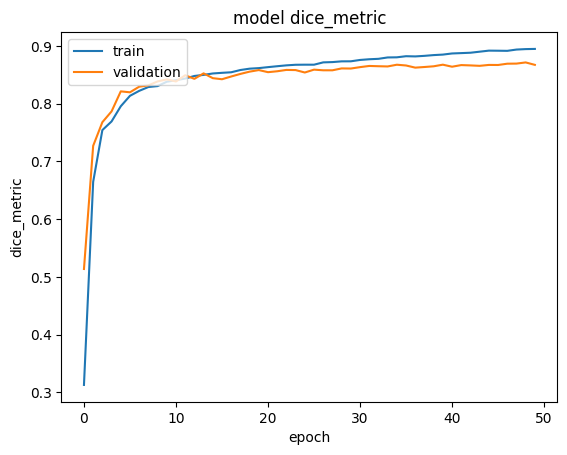

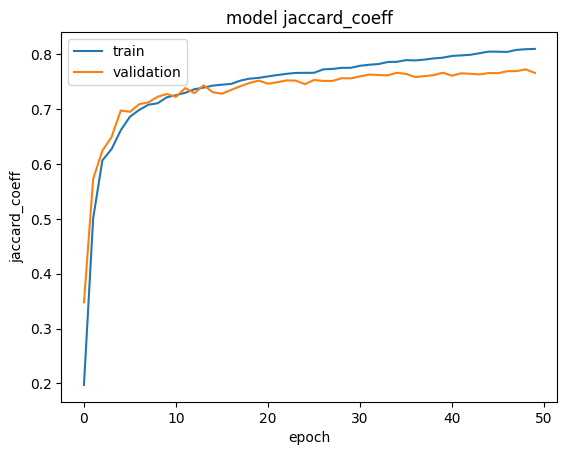

In [14]:
# list all data in history
# print(history.history.keys())     
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for dice metric
plt.plot(model_history.history['dice_metric'])
plt.plot(model_history.history['val_dice_metric'])
plt.title('model dice_metric')
plt.ylabel('dice_metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for jaccard coeff
plt.plot(model_history.history['jaccard_coeff'])     
plt.plot(model_history.history['val_jaccard_coeff'])
plt.title('model jaccard_coeff')
plt.ylabel('jaccard_coeff')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [15]:
# Compute and display the loss and accuracy of the trained model on the test set.
eval = model.evaluate(x_test, y_test)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}, dice metric = {}, jaccard coef = {}".format(eval[0], eval[1], eval[2], eval[3]))

43/43 [==============================] - 7s 158ms/step - loss: 0.0201 - accuracy: 0.9929 - dice_metric: 0.8562 - jaccard_coeff: 0.7497
Evaluation result on Test Data : Loss = 0.02010725438594818, accuracy = 0.9929141998291016, dice metric = 0.8561761379241943, jaccard coef = 0.7497119307518005


In [ ]:
model_path = '/content/gdrive/MyDrive/gp_models/2ch_125pat_50epoch/model'
model = tf.keras.models.load_model(model_path, custom_objects = {"dice_metric": dice_metric, "jaccard_coeff": jaccard_coeff})

# Check its architecture
model.summary()

In [10]:
x_test.shape[0]

1375

4/4 [==============================] - 1s 151ms/step - loss: 0.0132 - accuracy: 0.9946 - dice_metric: 0.8808 - jaccard_coeff: 0.7870
[0.8767164945602417, 0.8581125736236572, 0.8343045115470886, 0.8340599536895752, 0.8408742547035217, 0.8410556316375732, 0.8621739149093628, 0.8668426275253296, 0.8745236992835999, 0.8795065879821777, 0.8807555437088013]


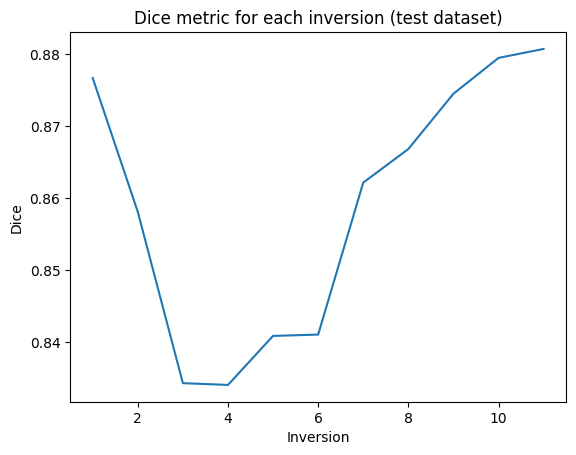

In [11]:
## More efficient way to calculate dice for each inversion
N = x_test.shape[0]
i1_indicies = np.arange(0, N, 11)
i2_indicies = np.arange(1, N, 11)
i3_indicies = np.arange(2, N, 11)
i4_indicies = np.arange(3, N, 11)
i5_indicies = np.arange(4, N, 11)
i6_indicies = np.arange(5, N, 11)
i7_indicies = np.arange(6, N, 11)
i8_indicies = np.arange(7, N, 11)
i9_indicies = np.arange(8, N, 11)
i10_indicies = np.arange(9, N, 11)
i11_indicies = np.arange(10, N, 11)

dices = []
inversions = []

for idx, i in enumerate([i1_indicies,i2_indicies,i3_indicies,i4_indicies,i5_indicies,i6_indicies,i7_indicies,i8_indicies,i9_indicies,i10_indicies,i11_indicies]):
    dice = model.evaluate(x_test[i], y_test[i])[2]
    dices.append(dice)
    inversions.append(idx+1)

print(dices)
################################################################
plt.title('Dice metric for each inversion (test dataset)')
plt.ylabel('Dice')
plt.xlabel('Inversion')
plt.plot(inversions,dices)         